<a href="https://colab.research.google.com/github/satyajitghana/TSAI-DeepVision-EVA4.0-Phase-2/blob/master/07-VariationalAutoEncoders/RedCar_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! nvidia-smi

Wed Sep 16 17:39:59 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
! git clone https://github.com/satyajitghana/TSAI-DeepVision-EVA4.0-Phase-2

# MNIST VAE

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import MNIST
import torchvision.utils as vutils

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from PIL import Image

from torchsummary import summary
sns.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Build the Models

In [ ]:
class Encoder(nn.Module):
    """
    Creates the Encoder

    nc (int): number of channels of the input image
    ndf (int): number of feature maps for the discriminator

    This uses the special Spectral Normalization ref: https://arxiv.org/abs/1802.05957
    """
    def __init__(self, nc: int = 1, ndf: int = 16, z_dim: int = 20):
        super(Encoder, self).__init__()

        self.main = nn.Sequential(
            # input is (nc) x 28 x 28
            nn.Conv2d(nc, ndf * 2, 3, 1, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.1, inplace=True),

            nn.Conv2d(ndf * 2, ndf * 2, 3, 1, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.1, inplace=True),

            nn.Conv2d(ndf * 2, ndf * 2, 4, 2, 2, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.1, inplace=True),

            # state size. (ndf*4) x 14 x 14
            nn.Conv2d(ndf * 2, ndf * 4, 3, 1, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.1, inplace=True),

            nn.Conv2d(ndf * 4, ndf * 4, 4, 2, 2, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.1, inplace=True),

            # state size. (ndf*4) x 7 x 7
            nn.Conv2d(ndf * 4, ndf * 4, 3, 1, 0, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.1, inplace=True),
            # state size. (ndf*4) x 5 x 5
        )

        self.gap = nn.AdaptiveAvgPool2d(1)

        self.mu = nn.Conv2d(ndf * 4, z_dim, 1, bias=False)
        self.logvar = nn.Conv2d(ndf * 4, z_dim, 1, bias=False)

    def forward(self, input):
        out = self.main(input)
        out = self.gap(out)
        mu = self.mu(out)
        logvar = self.logvar(out)
        return mu, logvar

In [ ]:
encoder = Encoder(nc=1, ndf=8).to(device)

In [ ]:
input = torch.randn(1, 1, 28, 28).to(device)
encoder(input)[0].shape, encoder(input)[1].shape

(torch.Size([1, 20, 1, 1]), torch.Size([1, 20, 1, 1]))

In [ ]:
summary(encoder, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             144
       BatchNorm2d-2           [-1, 16, 28, 28]              32
         LeakyReLU-3           [-1, 16, 28, 28]               0
            Conv2d-4           [-1, 16, 28, 28]           2,304
       BatchNorm2d-5           [-1, 16, 28, 28]              32
         LeakyReLU-6           [-1, 16, 28, 28]               0
            Conv2d-7           [-1, 16, 15, 15]           4,096
       BatchNorm2d-8           [-1, 16, 15, 15]              32
         LeakyReLU-9           [-1, 16, 15, 15]               0
           Conv2d-10           [-1, 32, 15, 15]           4,608
      BatchNorm2d-11           [-1, 32, 15, 15]              64
        LeakyReLU-12           [-1, 32, 15, 15]               0
           Conv2d-13             [-1, 32, 8, 8]          16,384
      BatchNorm2d-14             [-1, 3

In [ ]:
class Decoder(nn.Module):
    """
    Creates the Decoder

    nc (int): channels in the final output
    nz (int): size of the latent z vector
    ngf (int): number of feature maps for the generator
    """
    def __init__(self, nc: int = 1, ngf: int = 16, z_dim: int = 20):
        super(Decoder, self).__init__()

        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( z_dim, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*4) x 4 x 4
            nn.ConvTranspose2d( ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.Conv2d(ngf * 4, ngf * 4, 3, 1, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*3) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 2, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.Conv2d(ngf * 2, ngf * 2, 3, 1, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 14 x 14
            nn.ConvTranspose2d( ngf * 2, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.Conv2d(ngf * 2, nc, 3, 1, 1, bias=False),
            # state size. (ngf*2) x 28 x 28
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
decoder = Decoder(nc=1, ngf=8, z_dim=20).to(device)

In [ ]:
input = torch.randn(1, 20, 1, 1).to(device)
decoder(input).shape

torch.Size([1, 1, 28, 28])

In [ ]:
summary(decoder, (20, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1             [-1, 64, 4, 4]          20,480
       BatchNorm2d-2             [-1, 64, 4, 4]             128
              ReLU-3             [-1, 64, 4, 4]               0
   ConvTranspose2d-4             [-1, 32, 8, 8]          32,768
       BatchNorm2d-5             [-1, 32, 8, 8]              64
              ReLU-6             [-1, 32, 8, 8]               0
            Conv2d-7             [-1, 32, 8, 8]           9,216
       BatchNorm2d-8             [-1, 32, 8, 8]              64
              ReLU-9             [-1, 32, 8, 8]               0
  ConvTranspose2d-10           [-1, 16, 14, 14]           8,192
      BatchNorm2d-11           [-1, 16, 14, 14]              32
             ReLU-12           [-1, 16, 14, 14]               0
           Conv2d-13           [-1, 16, 14, 14]           2,304
      BatchNorm2d-14           [-1, 16,

In [ ]:
class MNISTVAE(nn.Module):
    def __init__(self, nc: int = 1, nf: int = 8, z_dims: int = 20):
        super(MNISTVAE, self).__init__()

        self.encoder = Encoder(nc, nf, z_dims)
        self.decoder = Decoder(nc, nf, z_dims)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu
    
    def reparam_like_train(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

    def forward(self, input):
        mu, logvar = self.encoder(input)
        z = self.reparameterize(mu, logvar)
        out = self.decoder(z)

        return out, mu, logvar


In [ ]:
mnistvae = MNISTVAE(nc=1, nf=24, z_dims=20).to(device)

In [ ]:
input = torch.randn(1, 1, 28, 28).to(device)
[x.shape for x in mnistvae(input)]

[torch.Size([1, 1, 28, 28]),
 torch.Size([1, 20, 1, 1]),
 torch.Size([1, 20, 1, 1])]

In [ ]:
summary(mnistvae, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 48, 28, 28]             432
       BatchNorm2d-2           [-1, 48, 28, 28]              96
         LeakyReLU-3           [-1, 48, 28, 28]               0
            Conv2d-4           [-1, 48, 28, 28]          20,736
       BatchNorm2d-5           [-1, 48, 28, 28]              96
         LeakyReLU-6           [-1, 48, 28, 28]               0
            Conv2d-7           [-1, 48, 15, 15]          36,864
       BatchNorm2d-8           [-1, 48, 15, 15]              96
         LeakyReLU-9           [-1, 48, 15, 15]               0
           Conv2d-10           [-1, 96, 15, 15]          41,472
      BatchNorm2d-11           [-1, 96, 15, 15]             192
        LeakyReLU-12           [-1, 96, 15, 15]               0
           Conv2d-13             [-1, 96, 8, 8]         147,456
      BatchNorm2d-14             [-1, 9

In [ ]:
def kld(mu, logvar):
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return KLD

def loss_function(y_pred, y_true):

    recon_x, mu, logvar = y_pred

    BCE = F.binary_cross_entropy(recon_x, y_true, reduction='sum')

    B, C, H, W = recon_x.size()
    KLD = kld(mu, logvar)
    KLD /= B

    return BCE + KLD

In [ ]:
input = torch.randn(32, 1, 28, 28).to(device)
y_true = torch.randn(32, 1, 28, 28).to(device)
output = mnistvae(input)
loss = loss_function(output, y_true)
loss

tensor(14960.5342, device='cuda:0', grad_fn=<AddBackward0>)

## Dataset

In [ ]:
train_loader = torch.utils.data.DataLoader(
    MNIST(root='data', train=True, transform=T.ToTensor(), download=True),
    batch_size=128,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
)

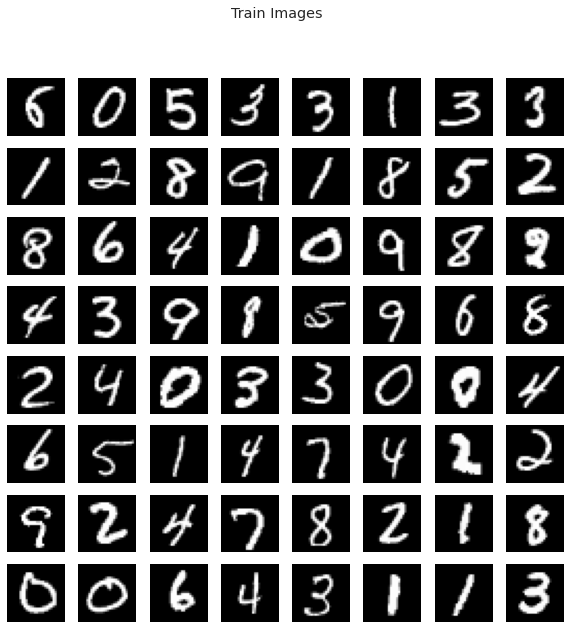

In [ ]:
# Plot some training images
plt.ioff()
real_batch, _ = next(iter(train_loader))
fig = plt.figure(figsize=(10, 10))
plt.title("Training Images")
for idx, image in enumerate(real_batch[:64]):
    plt.subplot(8, 8, idx+1)
    image.squeeze_(0)
    plt.imshow(image.cpu(), cmap='gray')
    plt.axis('off')
    plt.grid('off')
# plt.show()
fig.suptitle('Train Images')
plt.show()
# fig.tight_layout()
# fig.savefig('test.jpg')
# plt.close()

In [ ]:
def save_images(data, title='', dest='test.jpg'):
    plt.ioff()
    fig = plt.figure(figsize=(10, 10))
    # fetch the first 64 images only
    for idx, image in enumerate(data[:64]):
        plt.subplot(8, 8, idx+1)
        image.squeeze_(0)
        plt.imshow(image.cpu(), cmap='gray')
        plt.axis('off')
        plt.grid('off')
    fig.suptitle(title)
    fig.savefig(dest)
    plt.close()

## Train the Model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model = MNISTVAE(nc=1, nf=32, z_dims=10)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
from tqdm.auto import tqdm

def train_epoch(epoch, model, optimizer):
    model.train()

    model = model.to(device)

    train_loss = 0
    for batch_idx, (data, _) in enumerate(tqdm(train_loader)):
        data = data.to(device)

        optimizer.zero_grad() # zero out the gradients

        output = model(data) # forward pass

        loss = loss_function(output, data) # compute the loss

        loss.backward() # backprop the loss

        train_loss += loss.item()

        optimizer.step() # update the optimizer
    
    print(f'=> Epoch: {epoch}\tAverage Loss: {(train_loss / len(train_loader)):.4f}\n')

In [ ]:
NUM_EPOCHS = 10
out_images = Path('vae_output')
out_images.mkdir(parents=True, exist_ok=True)
for epoch in range(1, NUM_EPOCHS + 1):
    train_epoch(epoch, model, optimizer)

    # with torch.no_grad():
    #     model.eval()
    #     # `64 x z_dims` random array
    #     sample = torch.randn(64, 20, 1, 1).to(device)
    #     sample_out = model.decoder(sample)
    #     sample_out = torch.sigmoid(sample_out)

    # save_images(sample_out, f'Epoch {epoch:02}', dest=f'vae_output/epoch_{epoch:02}')


=> Epoch: 1	Average Loss: 16443.6890




=> Epoch: 2	Average Loss: 11349.6989




=> Epoch: 3	Average Loss: 10695.9913




=> Epoch: 4	Average Loss: 10463.6552




=> Epoch: 5	Average Loss: 10194.3758




=> Epoch: 6	Average Loss: 10072.2159




=> Epoch: 7	Average Loss: 10027.2879




=> Epoch: 8	Average Loss: 9866.0832




=> Epoch: 9	Average Loss: 9808.3158




=> Epoch: 10	Average Loss: 9678.6854



Let's try to see what the model outputs if we provide it with some random z vector

In [ ]:
with torch.no_grad():
    model.eval()
    sample = torch.randn(64, 10, 1, 1).to(device)
    output = model.decoder(sample)

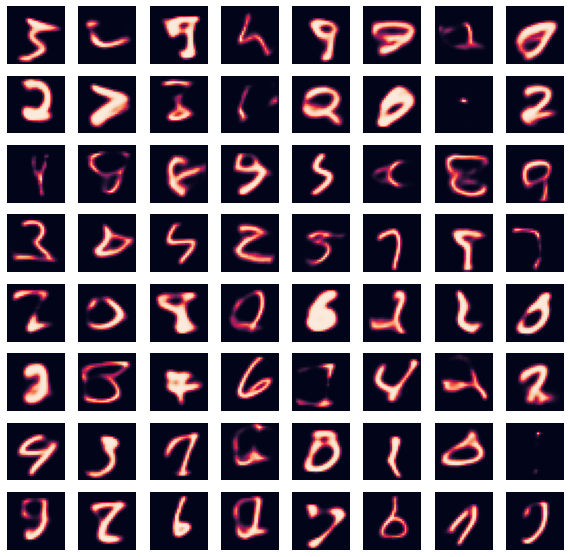

In [ ]:
fig = plt.figure(figsize=(10, 10))
for idx, image in enumerate(output[:64]):
    plt.subplot(8, 8, idx+1)
    image.squeeze_(0)
    plt.imshow(image.cpu())
    plt.axis('off')
    plt.grid('off')

plt.show()

## Lets see how the model reconstructs input images

In [ ]:
batch, _ = next(iter(train_loader))
with torch.no_grad():
    batch = batch.to(device)

    out, mu, logvar = model(batch)

In [ ]:
fig = plt.figure(figsize=(10, 10))
for idx, image in enumerate(out[:64]):
    plt.subplot(8, 8, idx+1)
    image.squeeze_(0)
    plt.imshow(image.cpu())
    plt.axis('off')
    plt.grid('off')
plt.tight_layout()
fig.canvas.draw()
predicted = np.array(fig.canvas.renderer.buffer_rgba())

In [ ]:
fig = plt.figure(figsize=(10, 10))
for idx, image in enumerate(batch[:64]):
    plt.subplot(8, 8, idx+1)
    image.squeeze_(0)
    plt.imshow(image.cpu())
    plt.axis('off')
    plt.grid('off')
plt.tight_layout()
fig.canvas.draw()
real = np.array(fig.canvas.renderer.buffer_rgba())

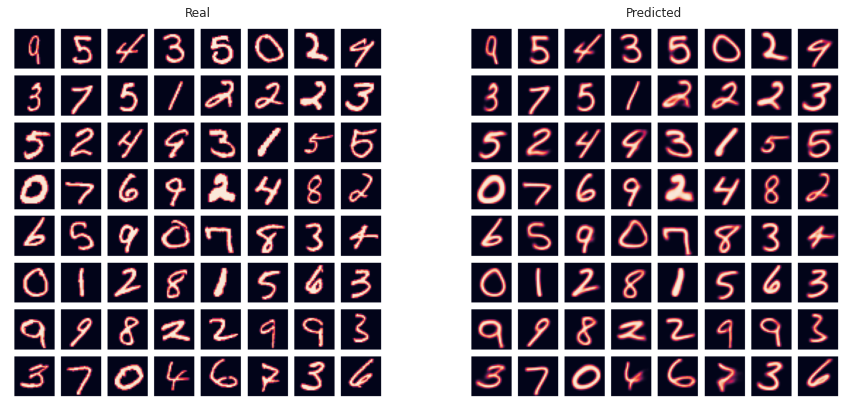

In [ ]:
fig = plt.figure(figsize=(15, 10))

plt.subplot(1, 2, 1)
plt.imshow(real)
plt.title('Real')
plt.grid('off')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(predicted)
plt.title('Predicted')
plt.grid('off')
plt.axis('off')

plt.show()

Playing with the z vector of the reconstructed images

In [ ]:
batch[0].shape

torch.Size([1, 28, 28])

In [ ]:
with torch.no_grad():
    mu, logvar = model.encoder(batch[3].unsqueeze_(0).to(device))
    z = model.reparameterize(mu, logvar)
    z[0][1][0] += 1.5
    z[0][0][0] += -1.5
    out = model.decoder(z)
    out = out.squeeze_(0)

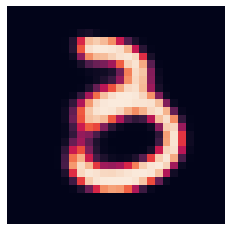

In [ ]:
plt.imshow(out[0].cpu())
plt.axis('off')
plt.grid('off')
plt.show()

In [ ]:
torch.save(model, 'mnist_vae.pt')

In [ ]:
torch.onnx.export(model.encoder,          
                  torch.randn(1, 1, 28, 28).to(device),              
                  "mnist_vae_encoder.onnx",  
                  export_params=True,        
                  opset_version=12,        
                  do_constant_folding=True,  
                  input_names = ['input'],   
                  output_names = ['output'], 
                  dynamic_axes={'input' : {0 : 'batch_size'},  
                                'output' : {0 : 'batch_size'}})

In [ ]:
torch.onnx.export(model.decoder,          
                  torch.randn(1, 10, 1, 1).to(device),              
                  "mnist_vae_decoder.onnx",  
                  export_params=True,        
                  opset_version=12,        
                  do_constant_folding=True,  
                  input_names = ['input'],   
                  output_names = ['output'], 
                  dynamic_axes={'input' : {0 : 'batch_size'},  
                                'output' : {0 : 'batch_size'}})